In [46]:
"""
Disv and Disu unstructured grid tests using gridgen and the underlying
flopy.discretization grid classes

"""

import os
import platform
import numpy as np

try:
    from shapely.geometry import Polygon
except ImportWarning as e:
    print("Shapely not installed, tests cannot be run.")
    Polygon = None


import flopy
from flopy.utils.gridgen import Gridgen

try:
    import matplotlib
    import matplotlib.pyplot as plt
    from matplotlib.collections import QuadMesh, PathCollection, LineCollection
except:
    print("Matplotlib not installed, tests cannot be run.")
    matplotlib = None
    plt = None

from ci_framework import base_test_dir, FlopyTestSetup

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set gridgen executable
gridgen_exe = "gridgen"
if platform.system() in "Windows":
    gridgen_exe += ".exe"
gridgen_exe = flopy.which(gridgen_exe)

# set mf6 executable
mf6_exe = "mf6"
if platform.system() in "Windows":
    mf6_exe += ".exe"
mf6_exe = flopy.which(mf6_exe)

# set mfusg executable
mfusg_exe = "mfusg"
if platform.system() in "Windows":
    mfusg_exe += ".exe"
mfusg_exe = flopy.which(mfusg_exe)

base_dir = base_test_dir("t504_test_mf6.ipynb", rel_path="temp", verbose=True)

VERBOSITY_LEVEL = 0




'\nDisv and Disu unstructured grid tests using gridgen and the underlying\nflopy.discretization grid classes\n\n'

adding test directory...temp\t504_mf6disu
Retaining test files
wrote temp\t504_mf6disu\grid.shp
Failed to get data for idomain array, disu package
Failed to get data for angle1 array, npf package
Failed to get data for angle2 array, npf package
Failed to get data for angle3 array, npf package
Failed to get data for k22 array, npf package
Failed to get data for k33 array, npf package
Failed to get data for wetdry array, npf package
wrote temp\t504_mf6disu\model.shp


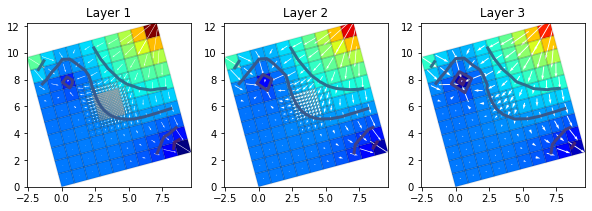

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disu...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package oc...
    loading package drn...
    loading package maw...
    loading package mvr...


MFDataException: An error occurred in data element "perioddata" model "mymodel" package "mvr". The error occurred while setting array data in the "_build_recarray" method.
Additional Information:
(1) An error occurred when storing data "perioddata" in a recarray. perioddata data is a one or two dimensional list containing the variables "<pname1> <id1> <pname2> <id2> <mvrtype> <value>" (some variables may be optional, see MF6 documentation), but data "[('drn', (0,), 'maw', (0,), 'factor', 1.0), ('drn', (1,), 'maw', (0,), 'factor', 1.0), ('drn', (2,), 'maw', (0,), 'factor', 1.0)]" was supplied.
(2) Error occurred while loading data "perioddata" in block "period" from file "D:\GWL\GHD021\gwmodel\construction\boundaries\LAK\angv7ss01\temp\t504_mf6disu\.\mymodel.mvr".

In [47]:
def test_mf6disu():
    # set up a gridgen workspace
    gridgen_ws = f"{base_dir}_mf6disu"
    test_setup = FlopyTestSetup(verbose=True, test_dirs=gridgen_ws, retain=True)

    name = "dummy"
    nlay = 3
    nrow = 10
    ncol = 10
    delr = delc = 1.0
    top = 1
    bot = 0
    dz = (top - bot) / nlay
    botm = [top - k * dz for k in range(1, nlay + 1)]

    # Create a dummy model and regular grid to use as the base grid for gridgen
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=gridgen_ws, exe_name="mf6"
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Create and build the gridgen model with a refined area in the middle
    g = Gridgen(dis, model_ws=gridgen_ws)
    polys = [Polygon([(4, 4), (6, 4), (6, 6), (4, 6)])]
    g.add_refinement_features(polys, "polygon", 3, layers=[0])
    g.build()
    disu_gridprops = g.get_gridprops_disu6()

    chdspd = []
    for x, y, head in [(0, 10, 1.0), (10, 0, 0.0)]:
        ra = g.intersect([(x, y)], "point", 0)
        ic = ra["nodenumber"][0]
        chdspd.append([(ic,), head])

    # build run and post-process the MODFLOW 6 model
    name = "mymodel"
    sim = flopy.mf6.MFSimulation(
        sim_name=name,
        sim_ws=gridgen_ws,
        exe_name="mf6",
        verbosity_level=VERBOSITY_LEVEL,
    )
    tdis = flopy.mf6.ModflowTdis(sim)
    ims = flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    disu = flopy.mf6.ModflowGwfdisu(gwf, **disu_gridprops)
    ic = flopy.mf6.ModflowGwfic(gwf)
    npf = flopy.mf6.ModflowGwfnpf(
        gwf, xt3doptions=True, save_specific_discharge=True
    )
    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
    budget_file = f"{name}.bud"
    head_file = f"{name}.hds"
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    
    # add DRN, MAW, MVR to test mvr load with disu
    model = sim.get_model(name)
    model.modelname = name
    model.modelname
    add_drn(model)
    add_maw(model)
    add_mvr(model)
    model.name_file.newtonoptions = ["NEWTON","UNDER RELAXATION"]
    sim.write_simulation()

    gwf.modelgrid.set_coord_info(angrot=15)

    # The flopy Gridgen object includes the plottable layer number to the
    # diagonal position in the ihc array.  This is why and how modelgrid.nlay
    # is set to 3 and ncpl has a different number of cells per layer.
    assert gwf.modelgrid.nlay == 3
    assert np.allclose(gwf.modelgrid.ncpl, np.array([436, 184, 112]))

    # write grid and model shapefiles
    fname = os.path.join(gridgen_ws, "grid.shp")
    gwf.modelgrid.write_shapefile(fname)
    fname = os.path.join(gridgen_ws, "model.shp")
    gwf.export(fname)

    if mf6_exe is not None:
        sim.run_simulation(silent=True)
        head = gwf.output.head().get_data()
        bud = gwf.output.budget()
        spdis = bud.get_data(text="DATA-SPDIS")[0]

        if matplotlib is not None:
            f = plt.figure(figsize=(10, 10))
            vmin = head.min()
            vmax = head.max()
            for ilay in range(gwf.modelgrid.nlay):
                ax = plt.subplot(1, gwf.modelgrid.nlay, ilay + 1)
                pmv = flopy.plot.PlotMapView(gwf, layer=ilay, ax=ax)
                ax.set_aspect("equal")
                pmv.plot_array(
                    head.flatten(), cmap="jet", vmin=vmin, vmax=vmax
                )
                pmv.plot_grid(colors="k", alpha=0.1)
                pmv.contour_array(
                    head,
                    levels=[0.2, 0.4, 0.6, 0.8],
                    linewidths=3.0,
                    vmin=vmin,
                    vmax=vmax,
                )
                ax.set_title(f"Layer {ilay + 1}")
                pmv.plot_vector(spdis["qx"], spdis["qy"], color="white")
            fname = "results.png"
            fname = os.path.join(gridgen_ws, fname)
            plt.savefig(fname)
            plt.show()
            plt.close("all")

            # check plot_bc works for unstructured mf6 grids
            # (for each layer, and then for all layers in one plot)
            plot_ranges = [range(gwf.modelgrid.nlay), range(1)]
            plot_alls = [False, True]
            for plot_range, plot_all in zip(plot_ranges, plot_alls):
                f_bc = plt.figure(figsize=(10, 10))
                for ilay in plot_range:
                    ax = plt.subplot(1, plot_range[-1] + 1, ilay + 1)
                    pmv = flopy.plot.PlotMapView(gwf, layer=ilay, ax=ax)
                    ax.set_aspect("equal")

                    pmv.plot_bc(
                        "CHD", plotAll=plot_all, edgecolor="None", zorder=2
                    )
                    pmv.plot_grid(
                        colors="k", linewidth=0.3, alpha=0.1, zorder=1
                    )

                    if len(ax.collections) == 0:
                        raise AssertionError(
                            "Boundary condition was not drawn"
                        )

                    for col in ax.collections:
                        if not isinstance(
                            col, (QuadMesh, PathCollection, LineCollection)
                        ):
                            raise AssertionError("Unexpected collection type")
                plt.close()

            # test plotting
            disu_dot_plot(gridgen_ws)

    return

def add_drn(model):
    maxbound = 3
    # build a stress_period_data template with 3 DRNs over stress period 1
    # 
    drn_periodrec = flopy.mf6.ModflowGwfdrn.stress_period_data.empty(
        model,
        maxbound=maxbound,
        boundnames=True,
        aux_vars=[],
        stress_periods=[0],
    )
    # define the three DRNs for stress period one
    #[cellid, elev, cond, aux, boundname]
    drn_periodrec[0][0] = (22, 0.66, 10.0, "First drn")
    drn_periodrec[0][1] = (458, 0.33, 10.0, "Second drn")
    drn_periodrec[0][2] = (642, 0.01, 10.0, "Third drn")
    # build the well package
    model.remove_package("drn")
    drn_package = flopy.mf6.ModflowGwfdrn(
        model,
        pname="drn",
        print_input=True,
        print_flows=True,
        maxbound=maxbound,
        stress_period_data=drn_periodrec,
        mover=True,
        boundnames=True,
        save_flows=True,
    )
    return drn_package
    
def add_maw(model):
    maxbound = 1
    # build a stress_period_data template with 1 well over stress period 1
    #maw_packagedata = flopy.mf6.ModflowGwfmaw.packagedata.empty(
    #    model,
    #    nmawwells=maxbound,
    #    boundnames=True,
    #)
    # define the well for stress period one. 
    # [wellno, radius, bottom, strt, condeqn, ngwfnodes, aux, boundname]
    maw_packagedata = [(0, 0.1, 0.33, 0.33, "THIEM", 1, "First Well")]
    
    # define connection data
    maw_conndata = [[0, 0, 9, 1.0, 0.33, 1.0, 0.1]]
    # define period data
    maw_perioddata = [[0, "RATE", 0.0]]
    
    # build the well package
    model.remove_package("maw")
    maw_package = flopy.mf6.ModflowGwfmaw(
        model,
        pname="maw",
        print_input=True,
        print_flows=True,
        nmawwells=maxbound,
        mover=True,
        packagedata=maw_packagedata,
        connectiondata=maw_conndata,
        perioddata=maw_perioddata,
        boundnames=True,
        save_flows=True,
    )    
    return maw_package

def add_mvr(model):
    mvr_paks = [
        ["drn"],
        ["maw"],
    ] # package names are from the nam file (right most entry) --> these go into mf6 memory manager for use in mover package etc

    mvr_spd = [
        ["drn", 0, "maw", 0, "FACTOR", 1.0],
        ["drn", 1, "maw", 0, "FACTOR", 1.0],
        ["drn", 2, "maw", 0, "FACTOR", 1.0],
    ]
    model.remove_package("mvr")
    mvr = flopy.mf6.ModflowGwfmvr(
        model,
        maxmvr=3,
        maxpackages=2,
        packages=mvr_paks,
        perioddata=mvr_spd,
    )
    return mvr

def disu_dot_plot(sim_path):
    # load up the disu example problem
    name = "mymodel"
    sim = flopy.mf6.MFSimulation.load(
        sim_name=name, version="mf6", exe_name="mf6", sim_ws=sim_path
    )
    gwf = sim.get_model(name)

    # check to make sure that ncpl was set properly through the diagonal
    # position of the ihc array
    assert np.allclose(gwf.modelgrid.ncpl, np.array([436, 184, 112]))

    # get the dis package
    dis = gwf.disu

    # try plotting an array
    top = dis.top
    ax = top.plot()
    assert ax
    plt.close("all")

    # try plotting a package
    ax = dis.plot()
    assert ax
    plt.close("all")

    # try plotting a model
    ax = gwf.plot()
    assert ax
    plt.close("all")

    return


if __name__ == "__main__":
    #test_mf6disv()
    test_mf6disu()
    #test_mfusg()

In [ ]:
test_mf6disu